# BME590 Unet++

In [1]:
# Import Packages
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tensorflow as tf
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import optimizers

#Resize the image to 96*96
IMG_WIDTH = 96
IMG_HEIGHT = 96
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
#Get Image ID
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [03:06<00:00,  3.59it/s]


Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 76.11it/s]


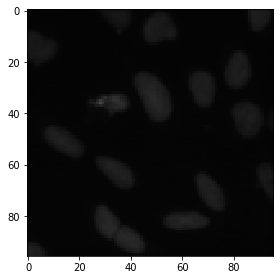

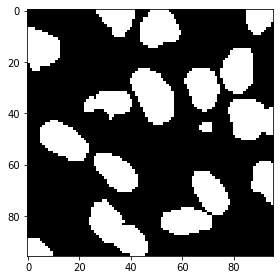

In [4]:
#Check train image and train mask
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [5]:
#Define Intersection over Union (IoU)
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)        
        if true == 0:
            metric += (pred == 0)
            continue
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union        
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10        
        metric += iou        
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [6]:
#Define BC Dice Loss Function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def bc_dice_loss(y_true, y_pred):
    return 0.5 * tf.python.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [33]:
#Set parameters
dropout_rate = 0.2
activation = "elu"
def conv_block(input_tensor, num_of_channels, kernel_size=3):
    x = Conv2D(num_of_channels, (kernel_size, kernel_size), activation=activation, kernel_initializer = 'he_normal', padding='same' )(input_tensor)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_of_channels, (kernel_size, kernel_size), activation=activation, kernel_initializer = 'he_normal', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    return x

In [34]:
#Build and train our neural network
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.2) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

up1_2 = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c2)
conv1_2 = concatenate([up1_2,c1],axis=3)
conv1_2 = conv_block(conv1_2, num_of_channels=32)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
conv2_2 = concatenate([up2_2, c2], axis=3)
conv2_2 = conv_block(conv2_2, num_of_channels=64)

up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, conv1_2], axis=3)
conv1_3 = conv_block(conv1_3, num_of_channels=32)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
conv3_2 = concatenate([up3_2, c3], axis=3)
conv3_2 = conv_block(conv3_2, num_of_channels=128)

up2_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], axis=3)
conv2_3 = conv_block(conv2_3, num_of_channels=64)

up1_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, conv1_2, conv1_3], axis=3)
conv1_4 = conv_block(conv1_4, num_of_channels=32)

c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

up4_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
conv4_2 = concatenate([up4_2, c4],  axis=3)
conv4_2 = conv_block(conv4_2,  num_of_channels=256)

up3_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, c3, conv3_2],  axis=3)
conv3_3 = conv_block(conv3_3, num_of_channels=128)

up2_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], axis=3)
conv2_4 = conv_block(conv2_4, num_of_channels=64)

up1_5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, conv1_2, conv1_3, conv1_4],  axis=3)
conv1_5 = conv_block(conv1_5, num_of_channels=32)

nestnet_output = Conv2D(1, (1, 1), activation ='sigmoid',
                        kernel_initializer= 'he_normal', padding='same')(conv1_5)
    
model = Model(inputs=[inputs], outputs=[nestnet_output])
model.compile(optimizer='adam', loss=bc_dice_loss,metrics=[my_iou_metric],lr = 3e-4)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 96, 96, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 96, 96, 32)   896         lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_59 (Dropout)            (None, 96, 96, 32)   0           conv2d_87[0][0]                  
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 96, 96, 32)   18464       concatenate_13[0][0]             
__________________________________________________________________________________________________
conv2d_transpose_20 (Conv2DTran (None, 24, 24, 128)  131200      dropout_77[0][0]                 
__________________________________________________________________________________________________
dropout_70 (Dropout)            (None, 24, 24, 128)  0           conv2d_102[0][0]                 
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 48, 48, 64)   36928       dropout_64[0][0]                 
__________________________________________________________________________________________________
dropout_61 (Dropout)            (None, 96, 96, 32)   0           conv2d_91[0][0]                  
__________

__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 96, 96, 32)   9248        dropout_73[0][0]                 
__________________________________________________________________________________________________
conv2d_transpose_22 (Conv2DTran (None, 96, 96, 32)   8224        dropout_81[0][0]                 
__________________________________________________________________________________________________
dropout_74 (Dropout)            (None, 96, 96, 32)   0           conv2d_106[0][0]                 
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 96, 96, 160)  0           conv2d_transpose_22[0][0]        
                                                                 conv2d_88[0][0]                  
                                                                 dropout_62[0][0]                 
          

In [43]:
#Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('Unet++.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
592/603 [============================>.] - ETA: 4s - loss: -0.9113 - my_iou_metric: 0.83 - ETA: 4s - loss: -0.9148 - my_iou_metric: 0.84 - ETA: 4s - loss: -0.9094 - my_iou_metric: 0.81 - ETA: 3s - loss: -0.9047 - my_iou_metric: 0.80 - ETA: 3s - loss: -0.9047 - my_iou_metric: 0.81 - ETA: 3s - loss: -0.9083 - my_iou_metric: 0.82 - ETA: 3s - loss: -0.9086 - my_iou_metric: 0.82 - ETA: 3s - loss: -0.9020 - my_iou_metric: 0.82 - ETA: 2s - loss: -0.9027 - my_iou_metric: 0.82 - ETA: 2s - loss: -0.9042 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9046 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9053 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9057 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9057 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9040 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9043 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9046 - my_iou_metric: 0.83 - ETA: 1s - loss: -0.9048 - my_iou_metric: 0.83 - ETA: 1s - loss: -0.9051 - my_iou_met

Epoch 5/100
592/603 [============================>.] - ETA: 3s - loss: -0.9263 - my_iou_metric: 0.87 - ETA: 3s - loss: -0.9194 - my_iou_metric: 0.85 - ETA: 3s - loss: -0.9217 - my_iou_metric: 0.85 - ETA: 3s - loss: -0.9140 - my_iou_metric: 0.84 - ETA: 3s - loss: -0.9157 - my_iou_metric: 0.84 - ETA: 3s - loss: -0.9159 - my_iou_metric: 0.84 - ETA: 3s - loss: -0.9163 - my_iou_metric: 0.85 - ETA: 2s - loss: -0.9115 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9098 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9086 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9082 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9086 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9048 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9039 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9035 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9043 - my_iou_metric: 0.83 - ETA: 2s - loss: -0.9041 - my_iou_metric: 0.83 - ETA: 1s - loss: -0.9057 - my_iou_metric: 0.83 - ETA: 1s - loss: -0.9052 - my_iou_metric: 0.83 - ETA: 1s - loss: -0.9064 - my_iou_

592/603 [============================>.] - ETA: 3s - loss: -0.9384 - my_iou_metric: 0.89 - ETA: 3s - loss: -0.9230 - my_iou_metric: 0.85 - ETA: 3s - loss: -0.9275 - my_iou_metric: 0.87 - ETA: 3s - loss: -0.9251 - my_iou_metric: 0.87 - ETA: 3s - loss: -0.9243 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9231 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9216 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9222 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9233 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9228 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9222 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9226 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9240 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9241 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9245 - my_iou_metric: 0.86 - ETA: 2s - loss: -0.9241 - my_iou_metric: 0.86 - ETA: 1s - loss: -0.9238 - my_iou_metric: 0.86 - ETA: 1s - loss: -0.9238 - my_iou_metric: 0.86 - ETA: 1s - loss: -0.9246 - my_iou_metric: 0.86 - ETA: 1s - loss: -0.9251 - my_iou_metric: 0.87

In [35]:
# Predict on train, validation and test
model = load_model('Unet++.h5', custom_objects={'my_iou_metric': my_iou_metric,'bc_dice_loss':bc_dice_loss})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

603/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 1s 2ms/sample
67/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

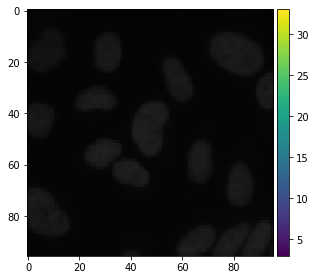

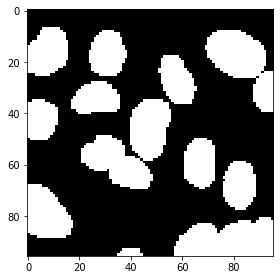

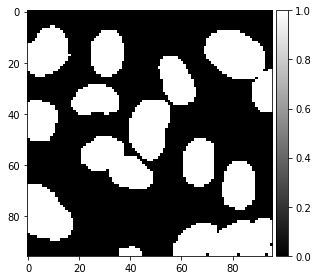

In [41]:
#Check train
ix = 10
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap = 'gray')
plt.show()

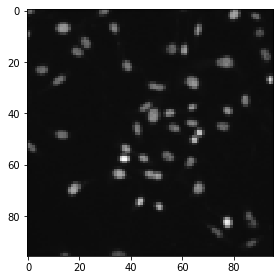

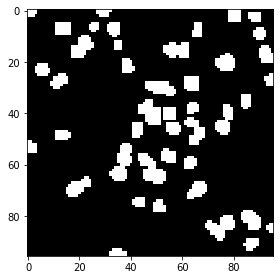

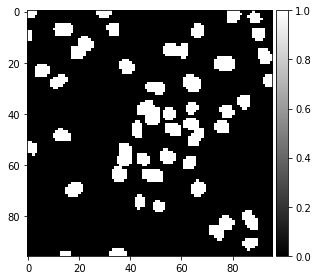

In [37]:
#Check validation
ix = 20
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]),cmap = 'gray')
plt.show()

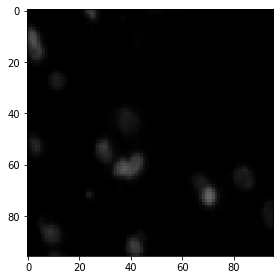

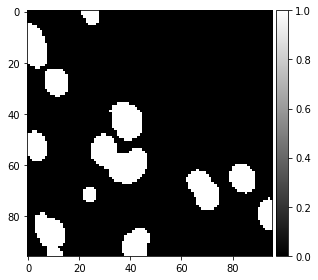

In [38]:
#Check test
ix = 11
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap = 'gray')
plt.show()

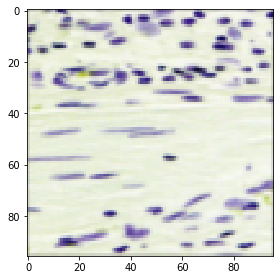

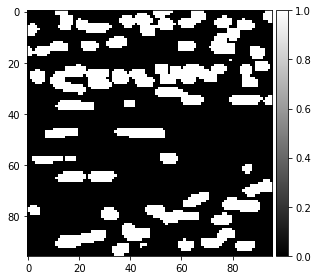

In [39]:
#Check test
ix = 12
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap = 'gray')
plt.show()

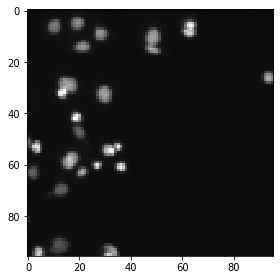

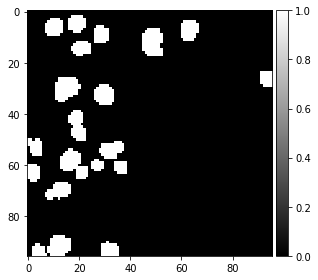

In [40]:
#Check test
ix = 13
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap = 'gray')
plt.show()